In [513]:
import pandas as pd

# import a csv file and convert it to a dataframe
filename = "delivery-truck-trip-data.csv"

# select the columns we want to use
columns = ['MaterialShipped', 'customerID', 'actual_eta', 'trip_start_date', 'originID', 'destinationID', 'distance_km','planned_eta']

# read the csv file and convert it to a dataframe and only 1000 rows
df = pd.read_csv(filename, usecols=columns, parse_dates=['trip_start_date', 'actual_eta', 'planned_eta'], nrows=6000)

# add a new column that is the difference between the actual eta and the trip start date
df['transit_time'] = df['actual_eta'] - df['trip_start_date']

# planned_eta has the format hh:mm.x, where x is a fraction of a minute (e.g. 0.5 is 30 seconds)
# convert the planned_eta to a timedelta without the fraction of a minute

# then add the fraction of a minute back
df['planned_eta'] = pd.to_timedelta(df['planned_eta'].str.split('.').str[0] + ':00') + pd.to_timedelta(df['planned_eta'].str.split('.').str[1] + ' minutes')

# hide actual eta and trip start date columns
df = df.drop(columns=['actual_eta', 'trip_start_date'])

# print the first 5 rows of the dataframe
df = df.dropna()
df.head()

,planned_eta,originID,destinationID,distance_km,customerID,MaterialShipped,transit_time
0,2 days 11:01:00,CHEPUZTVSHUA1,HOSHOSALLCCA2,320.0,ALLEXCHE45,BRACKET / GRAB HANDLE,10 days 23:39:00
1,0 days 22:30:00,CHEORADMRCCB1,CHEMATDMROPA7,103.0,DMREXCHEUX,ZB MODEL PLATE / 3143,0 days 20:25:00
2,2 days 11:25:00,CHEPONLUTCCA4,CHEPONLUTCCA4,300.0,LUTGCCHE06,LETTERING / FUSO,0 days 22:06:00
3,2 days 00:29:00,CHEORADMRCCB1,CHEMATDMROPA7,61.0,DMREXCHEUX,LU STRUT RA / RADIUS ROD,0 days 12:03:00
4,0 days 23:21:00,CHENETLUTCCA1,CHENETLUTCCA1,240.0,LUTGCCHE06,WISHBONE / V ROD/HDT,0 days 13:09:00


In [514]:
print(f"Customers: {df['customerID'].nunique()}")
print(f"Products: {df['MaterialShipped'].nunique()}")

# interesting statistics about the distance
print(f"Shortest distance: {df['distance_km'].min()}")
print(f"Longest distance: {df['distance_km'].max()}")
print(f"Average distance: {df['distance_km'].mean()}")

print(f"Number of deliveries that were late: {df[df['transit_time'] > df['planned_eta']].shape[0]}")

# filter out outliers using IQR
lower_bound = df['transit_time'].quantile(0.01)
upper_bound = df['transit_time'].quantile(0.99)
# print number of rows where the transit time is less than the lower bound or greater than the upper bound
print("Number of outliers:", df[(df['transit_time'] < lower_bound) | (df['transit_time'] > upper_bound)].shape[0])

# filter out rows where the transit time is less than the lower bound or greater than the upper bound
df = df[(df['transit_time'] > lower_bound) & (df['transit_time'] < upper_bound)]

print("Top 5 customers by number of deliveries:")
print(df['customerID'].value_counts().head())

print("Top 5 products by number of deliveries:")
print(df['MaterialShipped'].value_counts().head())

print("Top 5 routes by number of deliveries with average transit time:")
print(df.groupby(['originID', 'destinationID']).agg({'transit_time': ['count', 'mean']}).sort_values(by=('transit_time', 'count'), ascending=False).head())

Customers: 38
Products: 1177
Shortest distance: 0.0
Longest distance: 2954.7
Average distance: 574.9988663755458
Number of deliveries that were late: 3743
Number of outliers: 116
Top 5 customers by number of deliveries:
LTLEXMUM40    3029
FILEXCHE19     634
DMREXCHEUX     569
ALLEXCHE45     251
LUTGCCHE06     217
Name: customerID, dtype: int64
Top 5 products by number of deliveries:
AUTO PARTS                       1417
GRS STARTER                       217
EMPTY TRAYS                       158
M70 STARTER MOTOR 12V 0.9KW       126
SPARE PARTS AUTOMOBILE            114
Name: MaterialShipped, dtype: int64
Top 5 routes by number of deliveries with average transit time:
                            transit_time                          
                                   count                      mean
originID      destinationID                                       
CHEORADMRCCB1 CHEMATDMROPA7          242 1 days 02:03:13.636363636
GURJMATVSHUA1 CHEMMNFILCCA1          128    7 days 01:51

In [515]:
# Calculate the mse for the planned eta and the actual eta by converting the timedelta to minutes and then squaring the difference
def mse(actual, predicted):
    return (((actual - predicted).dt.total_seconds() / 3600) ** 2).sum() / actual.shape[0]

mse = mse(df['planned_eta'], df['transit_time'])
print(f"MSE: {mse}")

MSE: 3801484.1250724536


In [516]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# split the data into training, testing, and validation sets using a 80/10/10 split

train, test = train_test_split(df, test_size=0.2, random_state=42)
test, val = train_test_split(test, test_size=0.5, random_state=42)

# one-hot encode the customerID and MaterialShipped columns
customer_encoder = OneHotEncoder(handle_unknown='ignore')
customer_encoder.fit(train['customerID'].values.reshape(-1, 1))

product_encoder = OneHotEncoder(handle_unknown='ignore')
product_encoder.fit(train['MaterialShipped'].values.reshape(-1, 1))

# display the one-hot encoded columns

print(f"Total set size: {df.shape[0]}")
print(f"Training set size: {train.shape[0]}")
print(f"Testing set size: {test.shape[0]}")
print(f"Validation set size: {val.shape[0]}")

Total set size: 5609
Training set size: 4487
Testing set size: 561
Validation set size: 561


In [517]:
# Create a statistical model that predicts the transit time based on the distance
import statsmodels.api as sm

# create a linear regression model
model = sm.OLS(train['transit_time'].dt.total_seconds() / 3600, train['distance_km'])

# fit the model
results = model.fit()

t = test['transit_time']
p = results.predict(test['distance_km'])

mse_lin = 0
for actual, predicted in zip(t, p):
    mse_lin += (actual.total_seconds() / 3600 - predicted) ** 2
mse_lin /= t.shape[0]

print(f"MSE: {mse_lin}, Percent improvement: {100 * (mse - mse_lin) / mse}%")

MSE: 3647962.4006057666, Percent improvement: 4.038468119704723%


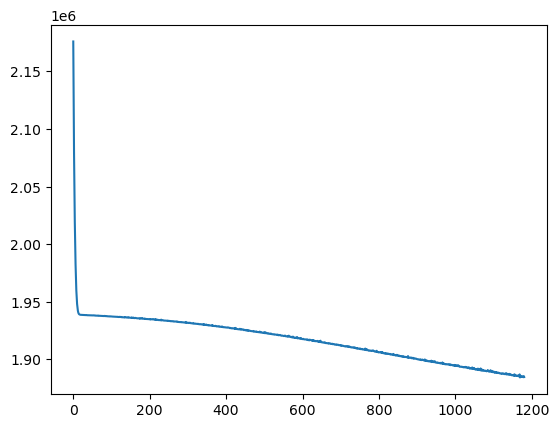

MSE: 3521300.1922715013, Percent improvement: 3.4721357959509738% (diff: -126662.20833426528)


In [518]:
# Create a multi-layer perceptron model that predicts the transit time based on the distance
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor

# create a multi-layer perceptron model
model = MLPRegressor(max_iter=10000, hidden_layer_sizes=(10,), random_state=42)

# fit the model
model.fit(train['distance_km'].values.reshape(-1, 1), train['transit_time'].dt.total_seconds() / 3600)

t = test['transit_time']
p = model.predict(test['distance_km'].values.reshape(-1, 1))

mse_mlp = 0
for actual, predicted in zip(t, p):
    mse_mlp += (actual.total_seconds() / 3600 - predicted) ** 2
mse_mlp /= t.shape[0]

# show graph of model training
plt.plot(model.loss_curve_)
plt.show()

print(f"MSE: {mse_mlp}, Percent improvement: {100 * (mse_lin - mse_mlp) / mse_lin}% (diff: {mse_mlp - mse_lin})")

In [519]:
# Create a random forest model that predicts the transit time based on the distance

from sklearn.ensemble import RandomForestRegressor

# create a random forest model
model = RandomForestRegressor(n_estimators=100)

# fit the model
model.fit(train['distance_km'].values.reshape(-1, 1), train['transit_time'].dt.total_seconds() / 3600)

t = test['transit_time']
p = model.predict(test['distance_km'].values.reshape(-1, 1))

mse_rf = 0
for actual, predicted in zip(t, p):
    mse_rf += (actual.total_seconds() / 3600 - predicted) ** 2
mse_rf /= t.shape[0]

print(f"MSE: {mse_rf}, Percent improvement: {100 * (mse_mlp - mse_rf) / mse_mlp}% (diff: {mse_rf - mse_mlp})")

MSE: 3470286.967775141, Percent improvement: 1.4487042203423466% (diff: -51013.2244963604)
